In [1]:
import pandas as pd
import re
import requests
from requests import get
from bs4 import BeautifulSoup
import time
import os
from env import github_token, github_username
import acquire as a
import prepare as p

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import json
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from time import strftime

pageCount = 15 
urlsList = []
base = "https://github.com/search?o=desc&p={}&q=shoes&s=stars&type=Repositories" #curly braces let you format


for x in range(pageCount)[0:]:
    urlsList.append(base.format(x))

urlsList

headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}

if headers["Authorization"] == "token " or headers["User-Agent"] == "":
    raise Exception("You need to follow the instructions marked TODO in this script before trying to use it")

def get_repo_links(github_token=github_token, github_username=github_username,
                                         topic='shoes', number_of_pages=5):
    '''
    Takes in a topic, your unique github API token, and your github username as
    strings and an interger for the number of pages to query
    Returns: list of repositories from GitHub in the form of
    '<username>/<repo_name>'
    '''
    # set URL without page number
    url = f'https://github.com/topics/{topic}?&s=stars&page='
    # set header for github auth
    headers = {"Authorization": f"token {github_token}",
               "User-Agent": github_username}
    # set empty list for total repos scraped
    list_of_repos = []
    # for each page in range of provided number
    for i in range(1, number_of_pages + 1):
        # obtain page data
        time.sleep(15)
        response = requests.get(url + str(i), headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        content = soup.find_all('h3')
        # set empty list to agg for each page
        page_list = []
        for repo in content:
            # confirms that h3 tag contains repo information
            if [re.search(r'(\S+)', x.text).group(1) for x in repo.find_all('a')] != []:
                # returns owner username and repo name
                user_name, repo_name = [re.search(r'(\S+)', x.text)\
                                         .group(1) for x in repo.find_all('a')]
                # add to page list for each repo on page
                page_list.extend([f'{user_name}/{repo_name}'])
        # add new page list into existing list for total repos
        list_of_repos.extend(page_list)
        print(f'Page {i} Completed')
    # saves returned list into .py file for calling in later functions
    with open("repos.py", "w") as repos:
        repos.write(f'REPOS = {list_of_repos}')
    return list_of_repos
    

repo_list = get_repo_links()

len(repo_list)

repo_list

In [2]:
df = a.scrape_github_data()

In [3]:
df = pd.DataFrame(df)

In [4]:
df.head()

,repo,language,readme_contents
0,shoes/shoes4,Ruby,# Shoes 4 [![Linux Build Status](https://secur...
1,druv5319/Sneaks-API,JavaScript,"\n<p align=""center"">\n \n<img src=""https://gi..."
2,shoes/shoes3,C,\n ((( |||_| ///\ [[[_ ...
3,WebAR-rocks/WebAR.rocks.hand,JavaScript,# JavaScript/WebGL lightweight and robust hand...
4,brandontruggles/Selenium-Shoe-Bot-NakedCPH,Python,# Selenium Shoe Bot (DEPRECATED!)\n\n**This pr...


In [5]:
df2 = df

In [6]:
list_of_langs = ['JavaScript', 'HTML', 'CSS', 'Ruby', 'Python', 'TypeScript']

In [7]:
df2['language'].dropna()

0           Ruby
1     JavaScript
2              C
3     JavaScript
4         Python
         ...    
92           CSS
93          HTML
95    JavaScript
96    TypeScript
97           CSS
Name: language, Length: 92, dtype: object

In [8]:
df2['language'].value_counts()

JavaScript          19
HTML                16
CSS                 12
Ruby                10
Python               8
TypeScript           6
Java                 3
Dart                 3
SCSS                 3
PHP                  3
Go                   2
C++                  2
Smarty               1
C                    1
Jupyter Notebook     1
AppleScript          1
Vue                  1
Name: language, dtype: int64

In [9]:
df['language'] = df['language'].replace('Java','Other')
df['language'] = df['language'].replace('Jupyter Notebook','Other')
df['language'] = df['language'].replace('AppleScript','Other')
df['language'] = df['language'].replace('Vue','Other')
df['language'] = df['language'].replace('Dart','Other')
df['language'] = df['language'].replace('SCSS','Other')
df['language'] = df['language'].replace('PHP','Other')
df['language'] = df['language'].replace('Go','Other')
df['language'] = df['language'].replace('C++','Other')
df['language'] = df['language'].replace('Smarty','Other')
df['language'] = df['language'].replace('C','Other')

In [10]:
list_of_other = ['Java', 'Jupyter Notebook', 'AppleScript', 'Vue', 'Dart', 'SCSS', 'PHP', 'Go', 'C++', 'Smarty', 'C']

In [11]:
for i in list_of_other:
    df['language'] = df['language'].replace(i, "Other")

In [12]:
df['language'].value_counts()

Other         21
JavaScript    19
HTML          16
CSS           12
Ruby          10
Python         8
TypeScript     6
Name: language, dtype: int64

In [13]:
def prep_article_data(df, column, exclude_words=[]):

    df['clean'] = df[column].apply(p.basic_clean)\
                            .apply(p.tokenize)\
                            .apply(p.remove_stopwords,
                                  exclude_words=exclude_words)
    
    df['stemmed'] = df['clean'].apply(p.stem)
    
    df['lemmatized'] = df['clean'].apply(p.lemmatize)
    
    return df[['repo', column,'clean', 'stemmed', 'lemmatized']]

In [14]:
prep_article_data(df, 'readme_contents', exclude_words = ['slammer'])

,repo,readme_contents,clean,stemmed,lemmatized
0,shoes/shoes4,# Shoes 4 [![Linux Build Status](https://secur...,shoes 4 linux build statushttpssecuretraviscio...,shoe 4 linux build statushttpssecuretraviscior...,shoe 4 linux build statushttpssecuretraviscior...
1,druv5319/Sneaks-API,"\n<p align=""center"">\n \n<img src=""https://gi...",p aligncenter img srchttpsgithubcomdruv5319sne...,p aligncent img srchttpsgithubcomdruv5319sneak...,p aligncenter img srchttpsgithubcomdruv5319sne...
2,shoes/shoes3,\n ((( |||_| ///\ [[[_ ...,_ _ _ artsy anyplatform app kit httpsgithubcom...,_ _ _ artsi anyplatform app kit httpsgithubcom...,_ _ _ artsy anyplatform app kit httpsgithubcom...
3,WebAR-rocks/WebAR.rocks.hand,# JavaScript/WebGL lightweight and robust hand...,javascriptwebgl lightweight robust hand tracki...,javascriptwebgl lightweight robust hand track ...,javascriptwebgl lightweight robust hand tracki...
4,brandontruggles/Selenium-Shoe-Bot-NakedCPH,# Selenium Shoe Bot (DEPRECATED!)\n\n**This pr...,selenium shoe bot deprecated program old longe...,selenium shoe bot deprec program old longer wo...,selenium shoe bot deprecated program old longe...
...,...,...,...,...,...
93,Kvas1407/ecomm-store-project,# Web Design & Development 1\n## E-Comm Websto...,web design development 1 ecomm webstore part 2...,web design develop 1 ecomm webstor part 2 outl...,web design development 1 ecomm webstore part 2...
94,bisofts/kingshoes,# kingshoes.-test.github.io,kingshoestestgithubio,kingshoestestgithubio,kingshoestestgithubio
95,yug20/react-gltf-models-shoes,![Screenshot from 2022-12-26 18-19-57](https:/...,screenshot 20221226 181957httpsuserimagesgithu...,screenshot 20221226 181957httpsuserimagesgithu...,screenshot 20221226 181957httpsuserimagesgithu...
96,Kenzothd/Shoedog_Client,# Getting Started with Create React App\n\nThi...,getting started create react app project boots...,get start creat react app project bootstrap cr...,getting started create react app project boots...


Other         21
JavaScript    19
HTML          16
CSS           12
Ruby          10
Python         8
TypeScript     6

In [15]:
def clean_text(text, extra_stopwords=['r', 'u', '2', 'ltgt']):
    
    wnl = nltk.stem.WordNetLemmatizer()
    
    stopwords = nltk.corpus.stopwords.words('english') + extra_stopwords
    
    clean_text = (unicodedata.normalize('NFKD', text)
                   .encode('ascii', 'ignore')
                   .decode('utf-8', 'ignore')
                   .lower())
    
    words = re.sub(r'[^\w\s]', '', clean_text).split()
    
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [16]:
other_words = clean_text(' '.join(df[df['language'] == 'Other']['readme_contents']))
javascript_words = clean_text(' '.join(df[df['language'] == 'JavaScript']['readme_contents']))
html_words = clean_text(' '.join(df[df['language'] == 'HTML']['readme_contents']))
css_words = clean_text(' '.join(df[df['language'] == 'CSS']['readme_contents']))
ruby_words = clean_text(' '.join(df[df['language'] == 'Ruby']['readme_contents']))
python_words = clean_text(' '.join(df[df['language'] == 'Python']['readme_contents']))
typescript_words = clean_text(' '.join(df[df['language'] == 'TypeScript']['readme_contents']))
all_words = clean_text(' '.join(df['readme_contents']))

In [17]:
other_counts = pd.Series(other_words).value_counts()
javascript_counts = pd.Series(javascript_words).value_counts()
html_counts = pd.Series(html_words).value_counts()
css_counts = pd.Series(css_words).value_counts()
ruby_counts = pd.Series(ruby_words).value_counts()
python_counts = pd.Series(python_words).value_counts()
typescript_counts = pd.Series(typescript_words).value_counts()
all_counts = pd.Series(all_words).value_counts()

In [18]:
word_freq = pd.concat([other_counts, javascript_counts, html_counts, css_counts, 
                       ruby_counts, python_counts, typescript_counts, all_counts], axis=1)
word_freq.head()

,0,1,2,3,4,5,6,7
kustomizationyml,37.0,NaN,NaN,NaN,NaN,NaN,NaN,37
shoe,33.0,21.0,23.0,12.0,85.0,8.0,3.0,206
manifest,30.0,NaN,NaN,NaN,NaN,NaN,NaN,30
application,20.0,3.0,NaN,NaN,8.0,NaN,NaN,35
40,20.0,NaN,NaN,NaN,NaN,NaN,NaN,20


In [19]:
word_freq.columns = ['other', 'javascript', 'html', 'css', 'ruby', 'python', 'typescript', 'all']
word_freq.fillna(0, inplace=True)
word_freq.head()

,other,javascript,html,css,ruby,python,typescript,all
kustomizationyml,37.0,0.0,0.0,0.0,0.0,0.0,0.0,37
shoe,33.0,21.0,23.0,12.0,85.0,8.0,3.0,206
manifest,30.0,0.0,0.0,0.0,0.0,0.0,0.0,30
application,20.0,3.0,0.0,0.0,8.0,0.0,0.0,35
40,20.0,0.0,0.0,0.0,0.0,0.0,0.0,20


In [20]:
word_freq.dtypes

other         float64
javascript    float64
html          float64
css           float64
ruby          float64
python        float64
typescript    float64
all             int64
dtype: object

In [21]:
word_freq = word_freq.astype('int')
word_freq.head()

,other,javascript,html,css,ruby,python,typescript,all
kustomizationyml,37,0,0,0,0,0,0,37
shoe,33,21,23,12,85,8,3,206
manifest,30,0,0,0,0,0,0,30
application,20,3,0,0,8,0,0,35
40,20,0,0,0,0,0,0,20


In [22]:
word_freq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4456 entries, kustomizationyml to repositoryhttpsgithubcomrhellishoesgithubapiarchivefeaturereadmezip
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   other       4456 non-null   int64
 1   javascript  4456 non-null   int64
 2   html        4456 non-null   int64
 3   css         4456 non-null   int64
 4   ruby        4456 non-null   int64
 5   python      4456 non-null   int64
 6   typescript  4456 non-null   int64
 7   all         4456 non-null   int64
dtypes: int64(8)
memory usage: 313.3+ KB


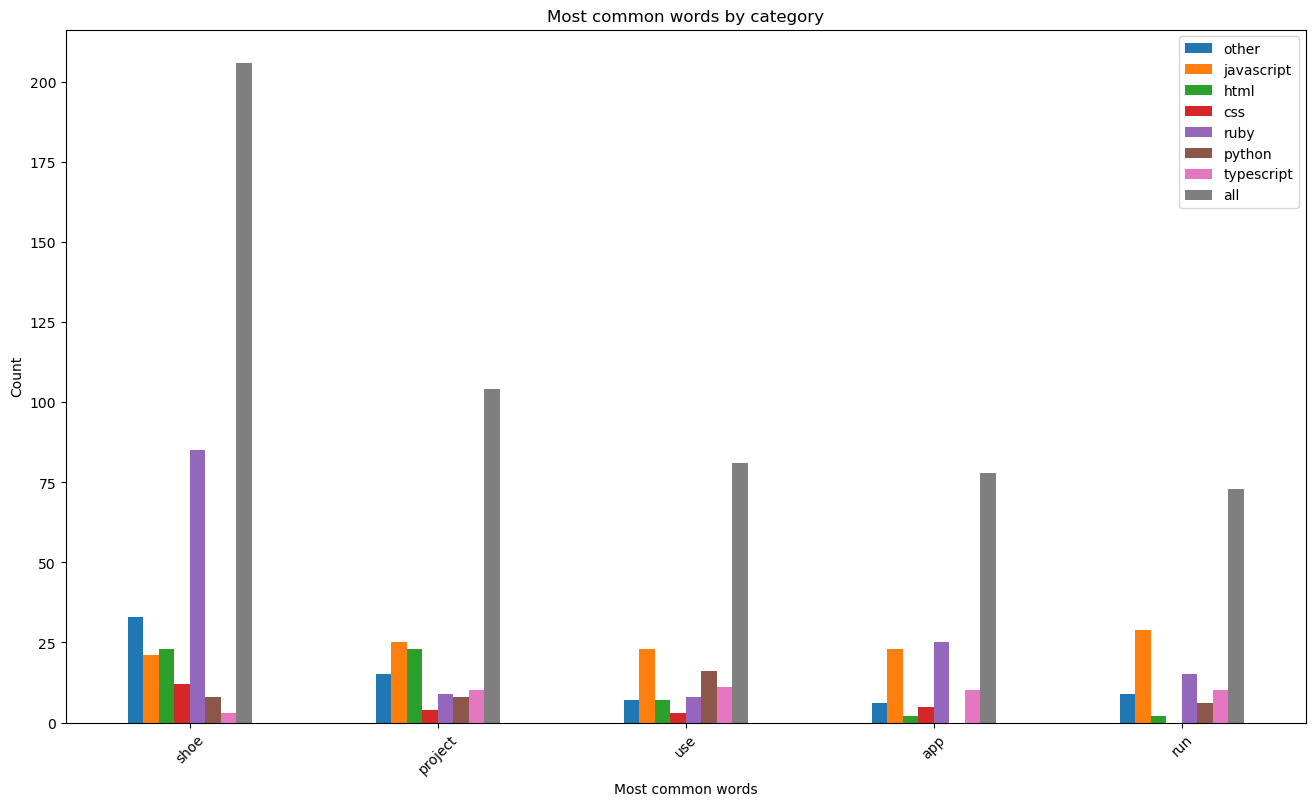

In [23]:
word_freq.sort_values('all', ascending=False).head(5).plot.bar(figsize=(16, 9))
plt.title('Most common words by category')
plt.ylabel('Count')
plt.xlabel('Most common words')
plt.xticks(rotation=45)
plt.show()

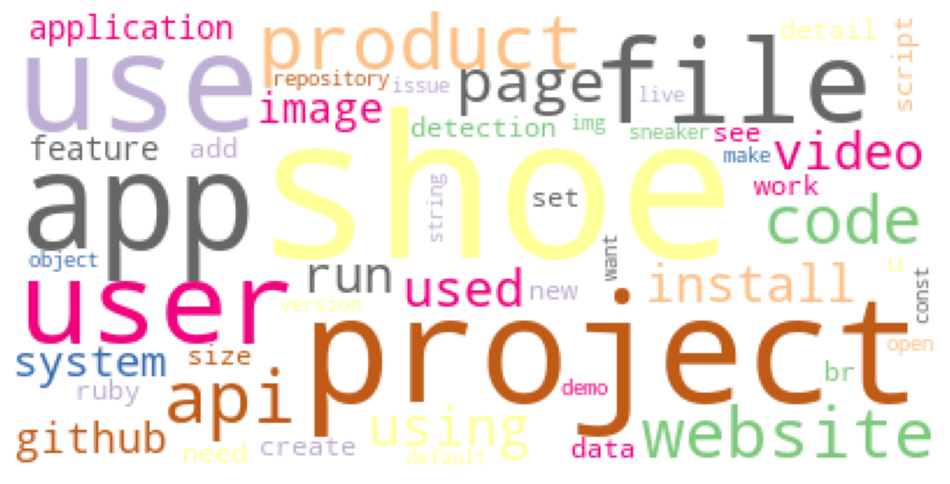

In [24]:
all_cloud = WordCloud(max_words = 50, background_color='white', colormap = 'Accent').generate(' '.join(all_words))
plt.figure(figsize=(12, 8))
plt.imshow(all_cloud)
plt.axis('off')
plt.show()

In [56]:
shoe_mask = np.array(Image.open("shoe_mask.png"))
shoe_mask


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [72]:
def transform_format(val):
    if val == 1:
        return 255
    else:
        return val


In [73]:
transformed_shoe_mask = np.ndarray((shoe_mask.shape[0],shoe_mask.shape[1]), np.int32)

for i in range(len(shoe_mask)):
    transformed_shoe_mask[i] = list(map(transform_format, shoe_mask[i]))

In [74]:
transformed_shoe_mask


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=int32)

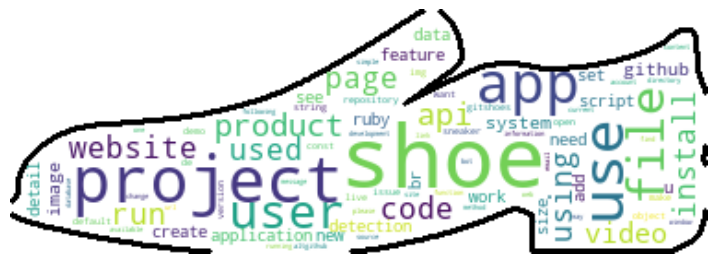

In [75]:
wc = WordCloud(background_color="white", max_words=150, mask=transformed_shoe_mask, contour_width=2, contour_color='black')

# Generate a wordcloud
wc.generate(' '.join(all_words))

# store to file
wc.to_file("shoe_mask.png")

# show
plt.figure(figsize=[9,6])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()